In [1]:
from sae_core.analysis import SAEAnalyzer
from sae_core.pretrained import PRETRAINED_SAES, list_pretrained, load_pretrained
from sae_core.data_processing.textbook_process import load_processed_data
from transformer_lens import HookedTransformer
import numpy as np

/Users/deancasey/Documents/Columbia/CRIS Lab/SAELens/cris_py312_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
qwen3_06B_l14_mlp_file_path = list_pretrained()[-1]
qwen3_06B_14_mlp_SAE, history = load_pretrained(qwen3_06B_l14_mlp_file_path, load_history=True)

In [ ]:
qwen3_06B = HookedTransformer.from_pretrained("qwen3-0.6b")

TypeError: Qwen3ForCausalLM.__init__() got an unexpected keyword argument 'history'

In [4]:
chemistry_texts = load_processed_data('sae_core/data/processed_data/processed_chem_text.json')

In [5]:
hook_layer = '14'
hook_name = 'hook_mlp_out'
qwen3_analyzer = SAEAnalyzer(qwen3_06B, qwen3_06B_l14_mlp_file_path, hook_layer, hook_name, chemistry_texts)

✓ Loaded SAE from qwen3_06B.blocks.14.hook_mlp_out.sae
✓ Model and SAE on device: mps:0
✓ Hook point: blocks.14.hook_mlp_out
✓ SAE dimensions: 1024 → 4096
✓ Dataset: 3437 texts


In [6]:
qwen3_analyzer.hook_point

'blocks.14.hook_mlp_out'

In [7]:
# Check:
print(f"Encoder bias mean: {qwen3_analyzer.sae.b_enc.mean()}")
print(f"Decoder bias norm: {qwen3_analyzer.sae.b_dec.norm()}")

print(f"Encoder weight mean: {qwen3_analyzer.sae.W_enc.mean()}")
print(f"Decoder weight norm: {qwen3_analyzer.sae.W_dec.norm()}")

Encoder bias mean: -0.01313820295035839
Decoder bias norm: 0.3140116035938263
Encoder weight mean: -1.1605297913774848e-05
Decoder weight norm: 64.0


In [8]:
np.sqrt(qwen3_06B.cfg.d_model *4)

64.0

In [9]:
paragraph_lengths = [len(par) for par in chemistry_texts]
lower_quartile = np.quantile(paragraph_lengths, 0.25)
upper_quartile = np.quantile(paragraph_lengths, 0.75)
mean = np.mean(paragraph_lengths)
median = np.median(paragraph_lengths)
lower_quartile, upper_quartile, mean, median

(28.0, 314.0, 213.84870526622055, 113.0)

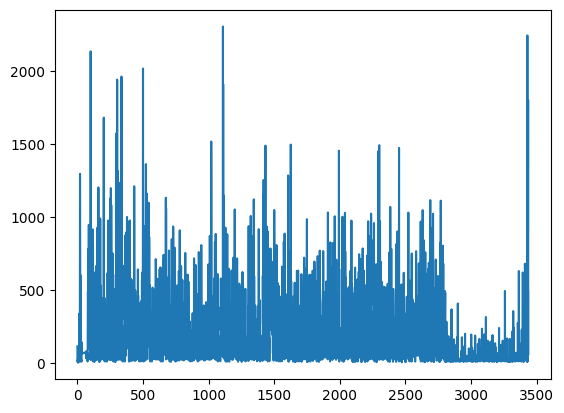

In [10]:
import matplotlib.pyplot as plt
plt.plot(paragraph_lengths)

In [11]:
large_text_list = [par for  par in chemistry_texts if len(par)>mean]
len(large_text_list)

1207

In [12]:
# Debug your dataset
print(f"Dataset size: {len(large_text_list[48:64])}")
for i, text in enumerate(large_text_list[48:64]):
    print(f"Text {i}: len={len(text)}, preview={text[:50]}")

Dataset size: 16
Text 0: len=283, preview=School-teacher, theologian, philosopher, scientist
Text 1: len=516, preview=The evolution of the oxygen begins at about 400°. 
Text 2: len=664, preview=~Directions for preparing oxygen.~ The manner of p
Text 3: len=244, preview=In the preparation of oxygen from potassium chlora
Text 4: len=277, preview=~The collection of gases.~ The method used for col
Text 5: len=405, preview=~Commercial methods of preparation.~ Oxygen can no
Text 6: len=563, preview=~Physical properties.~ Oxygen is a colorless, odor
Text 7: len=851, preview=~Chemical properties.~ At ordinary temperatures ox
Text 8: len=476, preview=The burning of a substance in oxygen is due to the
Text 9: len=795, preview=~Oxidation.~ The term _oxidation_ is applied to th
Text 10: len=929, preview=~Combustion; kindling temperature.~ When oxidation
Text 11: len=610, preview=~Oxides.~ The compounds formed by the oxidation of
Text 12: len=565, preview=~Products of combustion.~ The particular ox

In [23]:
# 1. Are activations centered properly?
import torch
tokens = large_text_list[0]
with torch.no_grad():
    _, cache = qwen3_06B.run_with_cache(tokens)
    acts = cache['blocks.14.hook_mlp_out']
    print(f"Activation mean: {acts.mean():.4f}")
    print(f"Activation std: {acts.std():.4f}")
    print(f"Activation range: [{acts.min():.4f}, {acts.max():.4f}]")

# 2. Check decoder norm during training
print(f"Decoder Frobenius norm: {torch.norm(qwen3_06B_14_mlp_SAE.W_dec):.4f}")
print(f"Expected: {np.sqrt(qwen3_06B_14_mlp_SAE.cfg.d_sae):.4f}")

# 3. Check if features are actually sparse
features = qwen3_06B_14_mlp_SAE.encode(acts.flatten(0, 1).to(qwen3_06B_14_mlp_SAE.device))
print(f"Feature sparsity: {(features == 0).float().mean():.4f}")  # Should be >0.9
print(f"L0 (features/token): {(features > 0).float().sum(dim=1).mean():.2f}")

Activation mean: 0.0123
Activation std: 1.1754
Activation range: [-5.6934, 11.8816]
Decoder Frobenius norm: 63.9849
Expected: 64.0000
Feature sparsity: 0.4849
L0 (features/token): 2109.70


Final epoch metrics:
  Loss: 18.8720
  Recon Loss: 0.1129
  L1 Loss: 0.0230
  Sparsity (L0): 0.00


/var/folders/h2/2nqjj9xd22j3snmk3tk5n0000000gn/T/ipykernel_54413/3042681595.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


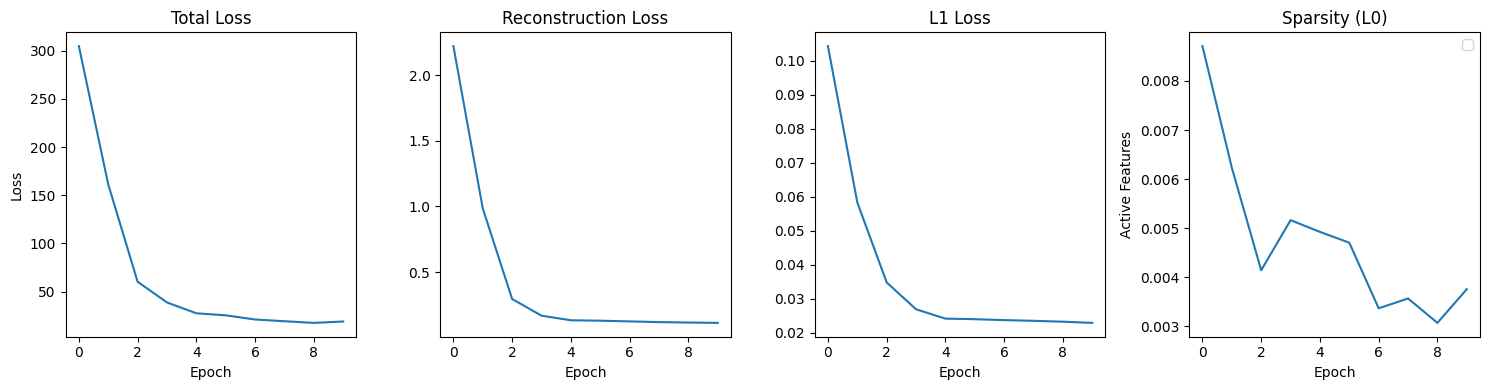

In [28]:
import matplotlib.pyplot as plt

# Load your training history
print(f"Final epoch metrics:")
print(f"  Loss: {history['loss'][-1]:.4f}")
print(f"  Recon Loss: {history['recon_loss'][-1]:.4f}")
print(f"  L1 Loss: {history['l1_loss'][-1]:.4f}")
print(f"  Sparsity (L0): {history['sparsity'][-1]:.2f}")

# Plot training curves
plt.figure(figsize=(15, 4))

plt.subplot(1, 4, 1)
plt.plot(history['loss'])
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 4, 2)
plt.plot(history['recon_loss'])
plt.title('Reconstruction Loss')
plt.xlabel('Epoch')

plt.subplot(1, 4, 3)
plt.plot(history['l1_loss'])
plt.title('L1 Loss')
plt.xlabel('Epoch')

plt.subplot(1, 4, 4)
plt.plot(history['sparsity'])
# plt.axhline(y=100, color='g', linestyle='--', label='Target ~100')
# plt.axhline(y=50, color='b', linestyle='--', label='Good <50')
plt.title('Sparsity (L0)')
plt.xlabel('Epoch')
plt.ylabel('Active Features')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
analyzer = SAEAnalyzer(
    model=qwen3_06B,
    sae_path=qwen3_06B_l14_mlp_file_path,
    layer=14,
    hook_name='hook_mlp_out',
    dataset=large_text_list[48:64]
)

results = analyzer.run_full_analysis(
    batch_size=8,
    save_path='analysis_results.json'
)

# Find interesting examples
examples = analyzer.find_max_activating_examples(feature_idx=99, top_k=10)

✓ Loaded SAE from qwen3_06B.blocks.14.hook_mlp_out.sae
✓ Model and SAE on device: mps:0
✓ Hook point: blocks.14.hook_mlp_out
✓ SAE dimensions: 1024 → 4096
✓ Dataset: 16 texts

Running Full SAE Analysis


[1/4] Computing Sparsity Metrics...
Computing sparsity metrics on 16 texts...


Sparsity:   0%|          | 0/2 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Sparsity: 100%|██████████| 2/2 [00:14<00:00,  7.39s/it]



✓ Sparsity Results:
  L0: 2084.86 ± 368.03 features/token
  L1: 1322.7358 ± 448.0281
  Tokens processed: 3104

[2/4] Identifying Dead Features...

✓ Dead Features (threshold=0.001):
  0/4096 (0.0%) dead features

[3/4] Computing Reconstruction Metrics...
Computing reconstruction metrics on 16 texts...


Reconstruction: 100%|██████████| 2/2 [00:41<00:00, 20.95s/it]



✓ Reconstruction Results:
  MSE: 3.986622
  Explained Variance: -2.5752 (-257.52%)
  Cosine Similarity: 0.6261
  Tokens processed: 3104

[4/4] Running Ablation Study...
Running ablation study on 16 texts...


Ablation:  25%|██▌       | 1/4 [01:39<04:57, 99.30s/it]


⚠️ WARNING: Baseline loss > Zero ablation loss!
   This suggests the hook point may be incorrect.


Ablation: 100%|██████████| 4/4 [07:16<00:00, 109.03s/it]



✓ Ablation Study Results:
  Baseline Loss:      15.0154
  Zero Ablation:      15.2157 (+0.2003)
  SAE Reconstruction: 13.5568 (+-1.4586)
  Loss Recovered:     828.20%
  Batches processed:  4

✓ Results saved to analysis_results.json

Analysis Complete!

Finding max activating examples for feature 99...


Max Act: 100%|██████████| 2/2 [00:45<00:00, 22.91s/it]


✓ Found top 10 activating examples for feature 99
  Max activation: 3.1864
  Min activation (in top-k): 2.4888


In [16]:
results.keys()

dict_keys(['sparsity', 'feature_freq', 'dead_features', 'reconstruction', 'ablation'])

In [17]:
results['sparsity']

{'l0_mean': 2084.860824742268,
 'l0_std': 368.0328890661432,
 'l1_mean': 1322.7357844716496,
 'l1_std': 448.0281461425181,
 'n_features': 4096,
 'n_tokens': 3104}

In [21]:
results['ablation']

{'baseline_loss': 15.015354633331299,
 'zero_ablation_loss': 15.215651988983154,
 'sae_reconstruction_loss': 13.556786060333252,
 'loss_recovered': 8.282016121736728,
 'n_batches': 4}

In [ ]:
qwen3_06B.cfg.d_model

1024

In [ ]:
qwen3_06B_14_mlp_SAE, qwen3_06B_14_mlp_SAE_history = load_pretrained(qwen3_06B_l14_mlp_file_path, load_history=True)